In [18]:
import networkx as nx
import pandas as pd
import math

In [2]:
def strength_centrality(G, out=True): 
    strengths = dict()
    sum_of_weights = 0
    for node in G.nodes:
        strengths[node] = 0
    for u, v, d in G.edges(data=True):
        if not out: #se non è out scambio i nodi
            k = v
            v = u
            u = k
        strengths[u] += d["weight"]
        sum_of_weights += d["weight"]
    
    for key in strengths.keys():
        strengths[key] = strengths[key] / sum_of_weights
        
    return dict(sorted(strengths.items(), key=lambda item: item[1], reverse=True)) 
        

In [3]:
Threshold = 1
path_dataset = "DatasetWithCountries.xlsx"

df = pd.read_excel(path_dataset)
df = df[df["Value (thousands USD)"] > Threshold]

# Coal

In [4]:
df_coal = df[df["Product"] == "Coal"]
df_coal.head()

,Exporter,Importer,Product,Value (thousands USD),ContinentExporter,ContinentImporter
5,ALB,SRB,Coal,33.708,EU,EU
87,AZE,GEO,Coal,43.500,AS,AS
118,ARG,BRA,Coal,229.782,SA,SA
123,ARG,CHL,Coal,1022.578,SA,SA
130,ARG,PRY,Coal,56.766,SA,SA


### Find Nodes and Edges

In [5]:
coal_nodes = list(set(df_coal["Exporter"].unique().tolist() + df_coal["Importer"].unique().tolist()))

coal_edges = [(row["Exporter"], row["Importer"], row["Value (thousands USD)"]) for (index, row) in df_coal.iterrows()]


## Create Graph

In [19]:
G_coal = nx.DiGraph()

G_coal.add_nodes_from(coal_nodes)
G_coal.add_weighted_edges_from(coal_edges)

inverse_weights = {}
for u, v, d in G_coal.edges(data=True):
    inverse_weights[(u,v)] = math.log(d["weight"]+1)
    
nx.set_edge_attributes(G_coal, inverse_weights, name="inverse_weights")


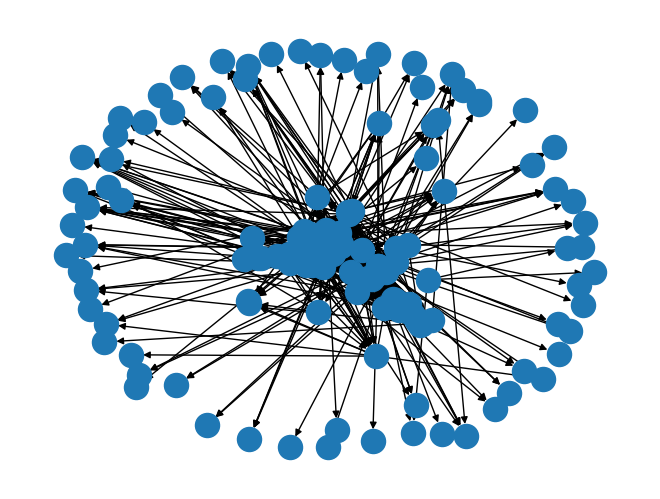

In [7]:
nx.draw(G_coal)

## Degree centrality

In [8]:
sorted(nx.out_degree_centrality(G_coal).items(), key=lambda item: item[1], reverse=True)

[('CHN', 0.43478260869565216),
 ('POL', 0.37681159420289856),
 ('DEU', 0.32608695652173914),
 ('RUS', 0.2898550724637681),
 ('USA', 0.2463768115942029),
 ('ITA', 0.2391304347826087),
 ('CZE', 0.2246376811594203),
 ('COL', 0.2246376811594203),
 ('ESP', 0.21014492753623187),
 ('GBR', 0.18115942028985507),
 ('BEL', 0.13043478260869565),
 ('NLD', 0.12318840579710146),
 ('LBN', 0.10144927536231885),
 ('HUN', 0.10144927536231885),
 ('JPN', 0.10144927536231885),
 ('ZAF', 0.10144927536231885),
 ('IND', 0.09420289855072464),
 ('FIN', 0.07246376811594203),
 ('AUT', 0.06521739130434782),
 ('FRA', 0.06521739130434782),
 ('AUS', 0.057971014492753624),
 ('DNK', 0.057971014492753624),
 ('TUR', 0.057971014492753624),
 ('ARE', 0.050724637681159424),
 ('IDN', 0.050724637681159424),
 ('BIH', 0.050724637681159424),
 ('KAZ', 0.043478260869565216),
 ('SWE', 0.043478260869565216),
 ('UKR', 0.043478260869565216),
 ('ROU', 0.043478260869565216),
 ('CAN', 0.036231884057971016),
 ('BGR', 0.036231884057971016),
 

In [9]:
sorted(nx.in_degree_centrality(G_coal).items(), key=lambda item: item[1], reverse=True)

[('IND', 0.18115942028985507),
 ('NLD', 0.13768115942028986),
 ('DEU', 0.13768115942028986),
 ('FRA', 0.13768115942028986),
 ('GBR', 0.13043478260869565),
 ('ESP', 0.12318840579710146),
 ('CHN', 0.11594202898550725),
 ('BEL', 0.11594202898550725),
 ('MYS', 0.10869565217391304),
 ('USA', 0.09420289855072464),
 ('AUT', 0.08695652173913043),
 ('TUR', 0.08695652173913043),
 ('SVK', 0.07971014492753624),
 ('POL', 0.07971014492753624),
 ('CHE', 0.07971014492753624),
 ('JPN', 0.07971014492753624),
 ('SWE', 0.07971014492753624),
 ('ITA', 0.07971014492753624),
 ('IDN', 0.07971014492753624),
 ('BGR', 0.07971014492753624),
 ('NOR', 0.07246376811594203),
 ('ROU', 0.07246376811594203),
 ('SRB', 0.06521739130434782),
 ('MAR', 0.06521739130434782),
 ('KOR', 0.06521739130434782),
 ('VNM', 0.057971014492753624),
 ('HUN', 0.057971014492753624),
 ('CAN', 0.057971014492753624),
 ('MEX', 0.057971014492753624),
 ('FIN', 0.057971014492753624),
 ('PAK', 0.057971014492753624),
 ('RUS', 0.057971014492753624),
 

### out_strength_centrality

In [10]:
out_strengths_centrality = strength_centrality(G_coal, out=True)
print(out_strengths_centrality)

{'POL': 0.25094190709138814, 'CHN': 0.14567359952310238, 'JPN': 0.11677536622331762, 'COL': 0.11658506686042959, 'RUS': 0.10397322368306132, 'DEU': 0.04570667004772732, 'USA': 0.033133994427505004, 'CZE': 0.028645574794181505, 'AUS': 0.0231616293007088, 'BIH': 0.016555099515807185, 'ITA': 0.01598502962764622, 'NLD': 0.014336125081390335, 'IDN': 0.012009723130542957, 'HUN': 0.008848657629880697, 'CHE': 0.00688328639807035, 'KOR': 0.006369809971995105, 'MOZ': 0.0061966192851157465, 'ESP': 0.005858969413654276, 'CHL': 0.004667710793851062, 'IND': 0.004306362666657526, 'ZWE': 0.003901081379335957, 'CAN': 0.0034357486553541158, 'NZL': 0.003390383305176054, 'BEL': 0.0032112441277748105, 'ZAF': 0.0030266057778914, 'SGP': 0.0027345963675736752, 'FIN': 0.0019956850549465665, 'UKR': 0.0015599885029209744, 'GBR': 0.0014130330070956866, 'HKG': 0.0013852197365283548, 'ROU': 0.0010643362205905987, 'EGY': 0.0008646674922607555, 'SWE': 0.0008099619903786364, 'FRA': 0.0006390107246824987, 'IRN': 0.0006

### in_strength_centrality

In [11]:
in_strengths_centrality = strength_centrality(G_coal, out=False)
print(in_strengths_centrality)

{'IND': 0.11271719056813763, 'CHN': 0.10744773538386787, 'DEU': 0.06543009172080239, 'BRA': 0.0524388730309094, 'MYS': 0.04713963775669941, 'GBR': 0.045170416584397924, 'ESP': 0.04293543786079357, 'KAZ': 0.041999819340095244, 'VNM': 0.03782535741616424, 'MEX': 0.03580367034238924, 'IDN': 0.031789505989605026, 'ROU': 0.029769867820429192, 'CAN': 0.028094993515914157, 'AUT': 0.027725245632610668, 'FRA': 0.02681497692956543, 'ITA': 0.022890967067525178, 'SRB': 0.020304113891343036, 'JPN': 0.020043009927156796, 'BEL': 0.017905579458321406, 'TUR': 0.015717180157651833, 'NOR': 0.015019321494768067, 'UKR': 0.014939416366105322, 'KOR': 0.011866609151615708, 'AUS': 0.010671167590556387, 'CZE': 0.010550177372355645, 'DZA': 0.009700386124710383, 'NLD': 0.00818162035642294, 'POL': 0.007914082738598125, 'FIN': 0.007843549126081779, 'USA': 0.007647200189554794, 'SVK': 0.007041916635462248, 'SWE': 0.004743250529815961, 'PAK': 0.004497797960034521, 'RUS': 0.004332518281640739, 'ZAF': 0.004189752358410

## Closeness centrality

In [22]:
sorted(nx.closeness_centrality(G_coal, distance="inverse_weights").items(), key=lambda item: item[1], reverse=True)

[('NLD', 0.07139699802305303),
 ('SGP', 0.06682238574677327),
 ('TUR', 0.06389358855383666),
 ('CHE', 0.06231795756799982),
 ('BGR', 0.06209099601316599),
 ('CRI', 0.05955313841078842),
 ('IND', 0.05919489194857846),
 ('ROU', 0.058053546589702056),
 ('BGD', 0.056727425905378374),
 ('ISR', 0.05615977738130137),
 ('JPN', 0.05605149133588795),
 ('GBR', 0.05590438704289993),
 ('ESP', 0.05562168840844325),
 ('KEN', 0.05554320480759921),
 ('FRA', 0.055490189185819834),
 ('PAK', 0.055352304652104355),
 ('CHN', 0.05458381805632818),
 ('GTM', 0.05452574045047849),
 ('MDA', 0.05439945512855523),
 ('GEO', 0.05394371199018778),
 ('AUS', 0.053547983704715196),
 ('DEU', 0.05313629655633194),
 ('USA', 0.052699154712475854),
 ('ISL', 0.052498656127946075),
 ('POL', 0.05226260193717346),
 ('RUS', 0.052168043250186535),
 ('ALB', 0.050790989072230085),
 ('HUN', 0.050586186407475156),
 ('GRC', 0.05043752527569516),
 ('ARE', 0.05012891046542961),
 ('MLI', 0.05005386416193786),
 ('LBN', 0.050019914638296456

## Betweeness Centrality

In [24]:
sorted(nx.betweenness_centrality(G_coal, weight="inverse_weights").items(), key=lambda item: item[1], reverse=True)

[('CHN', 0.10800803977573256),
 ('USA', 0.0804506505871152),
 ('DEU', 0.06923727917063366),
 ('NLD', 0.06786205437427272),
 ('IND', 0.0633661271554004),
 ('BEL', 0.05696604252618216),
 ('GBR', 0.0535808737966783),
 ('TUR', 0.050037025282978945),
 ('LBN', 0.04845022744102401),
 ('ESP', 0.047339468951655556),
 ('BGR', 0.04681053633767058),
 ('POL', 0.046175817200888605),
 ('RUS', 0.0316830635777002),
 ('ROU', 0.027610282450015865),
 ('THA', 0.024912726118692476),
 ('AUT', 0.022955675446948057),
 ('AUS', 0.022320956310166083),
 ('HUN', 0.021527557389188615),
 ('ZAF', 0.018618428012271235),
 ('JPN', 0.017454776261504282),
 ('SRB', 0.01655559081772982),
 ('DNK', 0.015867978419549348),
 ('FRA', 0.01512747275997038),
 ('SWE', 0.014545646884586903),
 ('CHL', 0.013752247963609436),
 ('LUX', 0.012377023167248492),
 ('ITA', 0.010578652279699566),
 ('ARG', 0.010419972495504071),
 ('COL', 0.007669522902782185),
 ('ALB', 0.0074050565957896955),
 ('PRT', 0.0074050565957896955),
 ('ARE', 0.00640008462